# Supervised learning the phases of a Rydberg atom array 

<br />
In this notebook we will explore the use of supervised learning applied to two different phases separated by a critical point in a Rydberg atom array. The two phases are a disordered paramagnet and an antiferromagnetically ordered state separated by a three-dimensional Ising critical point. The simulations are carried out using density matrix renormalization group. The datasets correspond to numerically simulated projective measurements in the computational basis $ \sigma = (\sigma_1,\ldots \sigma_N) $ across the different phases of the system. Here
$ \sigma_i \in \{0,1\}$ corresponds to the outcome of a projective measurement of operators 

$\sigma^{z}_i = \begin{pmatrix}
1 & 0 \\
0 & -1 
\end{pmatrix}$ applied independently on all the $N$ atoms of the system.


<br />

The notebook makes use of TensorFlow 2, Numpy, and Matplotlib for plots. 

### Importing Tensorflow, Numpy, and Matplotlib 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Details of the model, datasets,  and data loading 
We simulated an $8\times8$ lattice at different values of $\delta = -1.0, -0.5, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.5, 3.0, 4.0, 5.0$. In total, there are 10,000 samples at each delta. The corresponding labels are created also in split.sh such that data collected at Hamiltonian parameters in the interval $\delta \in \left[-5,1.3\right]$ will be labeled as belonging to the disordered phase and the rest is labeled as antiferromagnetically ordered phase. 

In [2]:
# Linear dimensions of the system
Nx = 8
Ny = 8

# different values of delta
delta = np.array([-5.0, -4.0, -3.0, -2.0, -1.0, -0.5, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.5, 3.0, 4.0, 5.0])

ntest = 1000  # Specifies the number of data points per value of delta in the test set 
ntrain = 9000 # Specifies the number of data points per value of delta in the training set

# Loading the datasets

#training set
train_config = np.loadtxt("../data/supervised/xtrain.txt") # spin configurations 
train_label = np.loadtxt("../data/supervised/ytrain.txt",dtype=np.uint8) # labels

#test set
test_config = np.loadtxt("../data/supervised/xtest.txt") # sping configurations
test_label  = np.loadtxt("../data/supervised/ytest.txt",dtype=np.uint8) # labels

#reshaping the training/testing configurations to 2 dimensional images with 1 "color"/sublattice input channel
train_config = np.reshape(train_config,(train_config.shape[0],Nx,Ny,1))
test_config = np.reshape(test_config,(test_config.shape[0],Nx,Ny,1))

#reshaping the labels
test_label  = np.reshape(test_label,(test_label.shape[0],1))
train_label = np.reshape(train_label,(train_label.shape[0],1))

# Names for the phases  
class_names = ['disordered', 'ordered']

### Visualizing a few configurations 


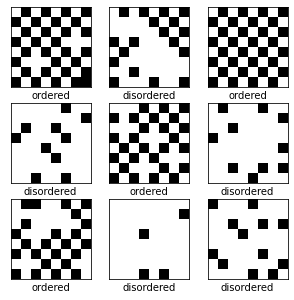

In [3]:
#plot a few configurations
plt.rcParams['figure.figsize'] = [5, 5] # figure size
Nfigs = 3 # sqrt(Number of figures you would like to plot)
randomize = np.arange(test_config.shape[0]) # Random selection of configurations from the test set
np.random.shuffle(randomize)
randomize = randomize[0:Nfigs*Nfigs] 
x = test_config[randomize]
y = test_label[randomize]

for i in range(Nfigs*Nfigs):
    plt.subplot(Nfigs,Nfigs,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(np.reshape(x[i],(Nx,Ny)), cmap=plt.cm.binary)
    plt.xlabel(class_names[y[i][0]])

plt.show()

### Defining the classifier and its optimization
We use a convolutional neural network to classify the configurations. The convolutional neural network has the structure depicted in the figure below. It contains two convolutional layers followed by two dense layers and a softmax that produces a probabilistic output of the neural network.  
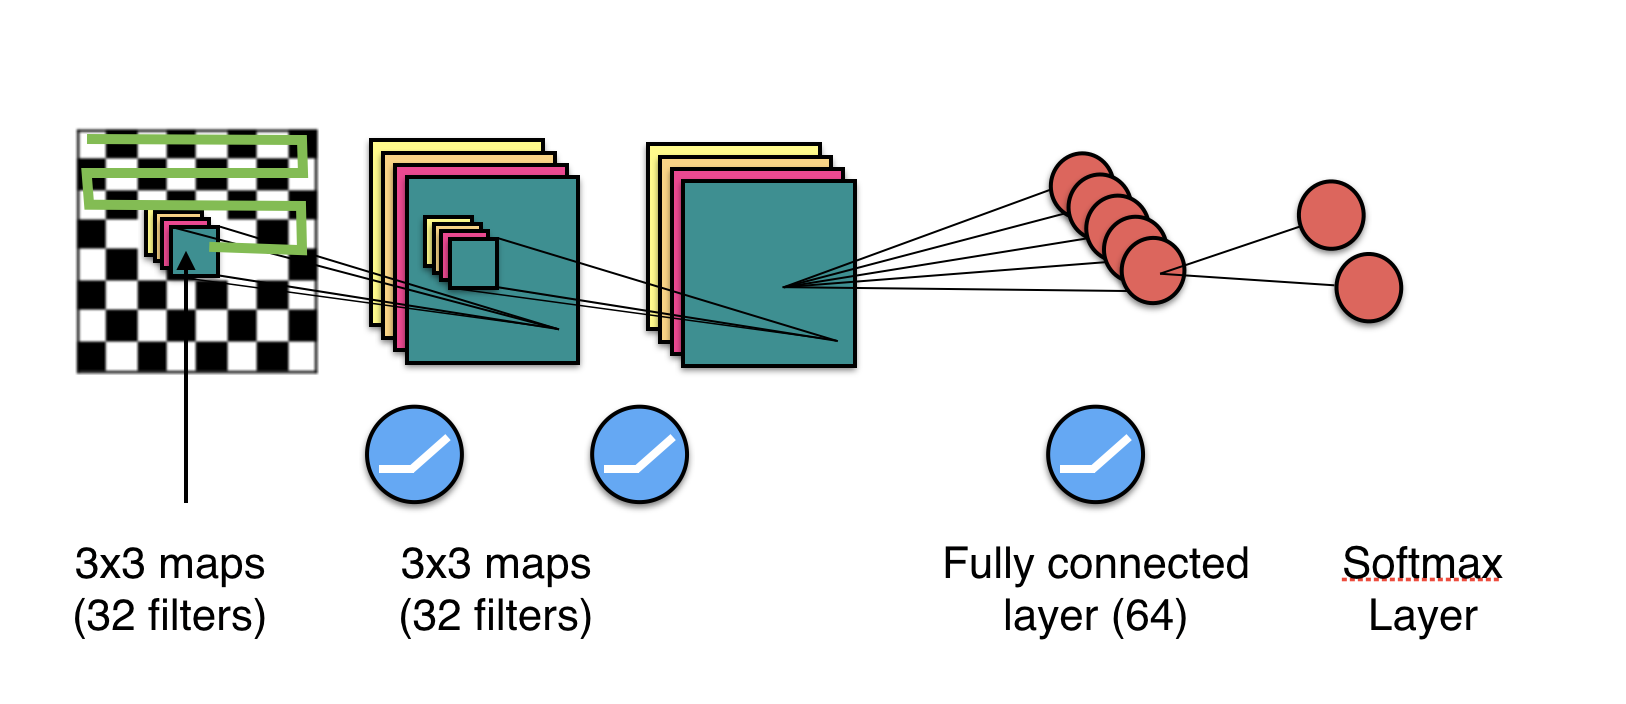

This architecture corresponds to the following TensorFlow operations

In [4]:
# Defining the Convolutional neural network

# 2 Convolutional layers
model = models.Sequential() # initializes the model
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(Nx, Ny, 1))) # firt conv. layer
model.add(layers.Conv2D(32, (3, 3), activation='relu')) # second conv. layer

# 2 Dense layers
model.add(layers.Flatten()) # Flatten the outcome of the second conv. layer to a vector
model.add(layers.Dense(64, activation='relu')) # apply the first dense layer
model.add(layers.Dense(2)) # second layer which outputs the "logits" of the softmax layer


# Compiling the model, defining the cost function, and specifying which optimizer will be used. Here
# we use the adam optimizer and use categorical cross entropy using the logits from the output by the dense layer
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Training and evaluating the model 
Now we use the TensorFlow function fit to train the model


In [5]:
#training the model for a total of two epochs=5
history = model.fit(train_config, train_label, epochs=5,
                    validation_data=(test_config, test_label))


# Evaluating the overall model
# test_loss corresponds to the value of the cross entropy on the test set
# test_acc corresponds to the accuracy of the predictions on the test set
test_loss, test_acc = model.evaluate(test_config,  test_label, verbose=2)

Epoch 1/5
7313/7313 [==============================] - 8s 1ms/step - loss: 0.0990 - accuracy: 0.9610 - val_loss: 0.0937 - val_accuracy: 0.9618
Epoch 2/5
7313/7313 [==============================] - 8s 1ms/step - loss: 0.0925 - accuracy: 0.9627 - val_loss: 0.0943 - val_accuracy: 0.9621
Epoch 3/5
7313/7313 [==============================] - 8s 1ms/step - loss: 0.0901 - accuracy: 0.9640 - val_loss: 0.0975 - val_accuracy: 0.9607
Epoch 4/5
7313/7313 [==============================] - 8s 1ms/step - loss: 0.0885 - accuracy: 0.9645 - val_loss: 0.0972 - val_accuracy: 0.9606
Epoch 5/5
7313/7313 [==============================] - 8s 1ms/step - loss: 0.0866 - accuracy: 0.9653 - val_loss: 0.0984 - val_accuracy: 0.9617
813/813 - 0s - loss: 0.0984 - accuracy: 0.9617


## Visualizing the trained model and its predictions
Using the test set, we now visualize how the model performs predictions across the different points in the phase diagram.  

In [6]:
# Defining useful arrays for plotting
test_l = np.zeros(delta.shape[0]) # test loss as a function of delta
test_ac = np.zeros(delta.shape[0]) # test accuracy as a function of delta
neural_output = np.zeros((delta.shape[0],2)) # Average over the test set of the neural output as a function of delta
neural_output_2 = np.zeros((delta.shape[0],2)) # error bar over the test set of the neural output as a function of delta

for i in range(delta.shape[0]):
    test_l[i], test_ac[i] = model.evaluate(test_config[i*ntest:i*ntest+ntest],  test_label[i*ntest:i*ntest+ntest], verbose=0)
    model_output_test_set = tf.nn.softmax(model(test_config[i*ntest:i*ntest+ntest]))
    neural_output[i] = np.mean(model_output_test_set)
    neural_output_2[i] = np.sqrt(np.abs(np.mean(model_output_test_set**2)-neural_output[i]**2)/model_output_test_set.shape[0])
    neural_output[i] = np.mean(tf.nn.softmax(model(test_config[i*ntest:i*ntest+ntest])),axis=0)       

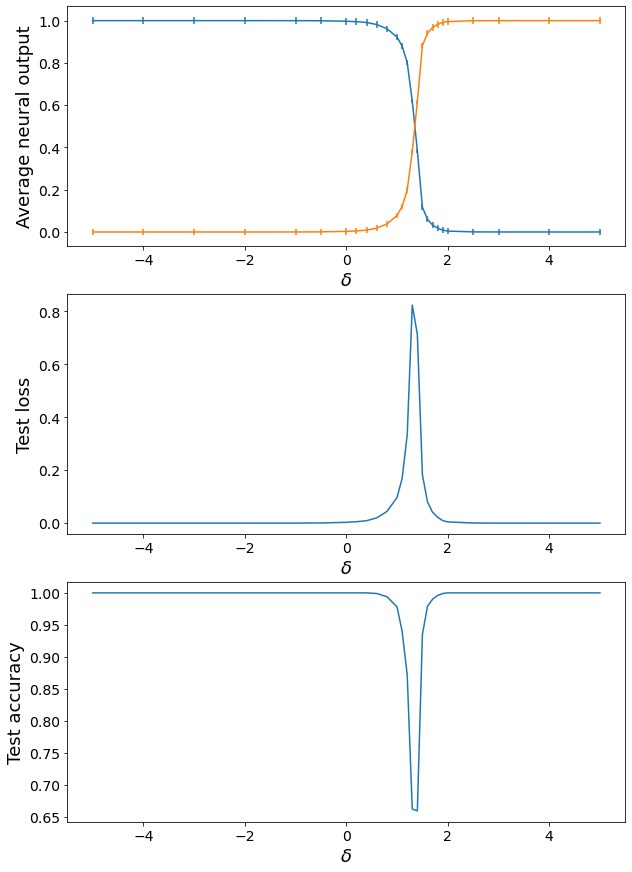

In [7]:
# Producing the plots 
plt.rcParams['figure.figsize'] = [10, 15] # figure size

plt.subplot(3,1,1)

# Neural outcome vs delta
plt.grid(False)
plt.errorbar(delta,neural_output[:,0],  yerr=neural_output_2[:,0], label='ord')
plt.errorbar(delta,neural_output[:,1],  yerr=neural_output_2[:,1], label='disord')
plt.xlabel("$\delta$",fontsize=18)
plt.ylabel("Average neural output",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.subplot(3,1,2)

#Test loss vs delta
plt.grid(False)
plt.plot(delta,test_l)
plt.xlabel("$\delta$",fontsize=18)
plt.ylabel("Test loss",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(3,1,3)

#Test accuracy vs delta
plt.grid(False)
plt.grid(False)
plt.plot(delta,test_ac)
plt.xlabel("$\delta$",fontsize=18)
plt.ylabel("Test accuracy",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()